In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

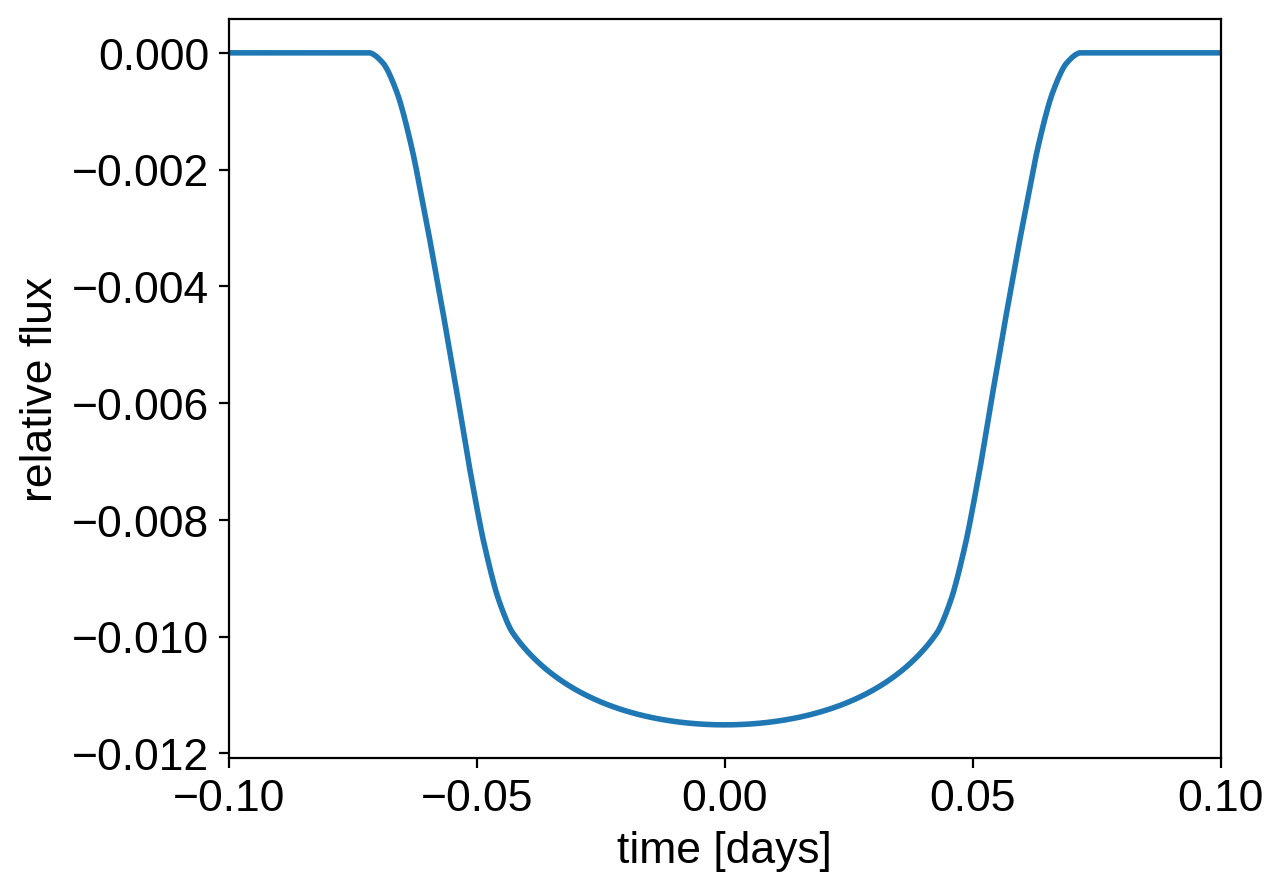

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.478798e+04]

1it [00:00, 257.15it/s, logp=2.478798e+04]

2it [00:00, 342.91it/s, logp=2.478798e+04]

3it [00:00, 391.78it/s, logp=-4.973052e+09]

4it [00:00, 413.96it/s, logp=2.478859e+04] 

5it [00:00, 424.89it/s, logp=2.478913e+04]

6it [00:00, 429.96it/s, logp=2.478977e+04]

7it [00:00, 439.16it/s, logp=2.479074e+04]

8it [00:00, 449.71it/s, logp=2.478483e+04]

9it [00:00, 460.11it/s, logp=2.479082e+04]

10it [00:00, 467.24it/s, logp=2.479098e+04]

11it [00:00, 475.10it/s, logp=2.479151e+04]

12it [00:00, 479.98it/s, logp=2.479065e+04]

13it [00:00, 477.23it/s, logp=2.479174e+04]

14it [00:00, 464.11it/s, logp=2.479145e+04]

15it [00:00, 470.11it/s, logp=2.479182e+04]

16it [00:00, 473.52it/s, logp=2.479195e+04]

17it [00:00, 478.77it/s, logp=2.479239e+04]

18it [00:00, 473.47it/s, logp=2.479094e+04]

19it [00:00, 479.60it/s, logp=2.479253e+04]

20it [00:00, 479.69it/s, logp=2.479279e+04]

21it [00:00, 473.74it/s, logp=2.479323e+04]

22it [00:00, 475.29it/s, logp=2.479351e+04]

23it [00:00, 479.42it/s, logp=2.479354e+04]

24it [00:00, 479.44it/s, logp=2.479354e+04]

25it [00:00, 479.03it/s, logp=2.479354e+04]

26it [00:00, 479.76it/s, logp=2.479354e+04]

27it [00:00, 482.61it/s, logp=2.479354e+04]

28it [00:00, 485.53it/s, logp=2.479354e+04]

29it [00:00, 488.18it/s, logp=2.479354e+04]

30it [00:00, 489.92it/s, logp=2.479354e+04]

31it [00:00, 489.84it/s, logp=2.479354e+04]

32it [00:00, 491.03it/s, logp=2.479354e+04]

33it [00:00, 491.43it/s, logp=2.479354e+04]

34it [00:00, 494.54it/s, logp=2.479354e+04]

35it [00:00, 493.38it/s, logp=2.479354e+04]

36it [00:00, 495.89it/s, logp=2.479354e+04]

37it [00:00, 497.83it/s, logp=2.479354e+04]

38it [00:00, 499.49it/s, logp=2.479354e+04]

39it [00:00, 499.06it/s, logp=2.479354e+04]

40it [00:00, 500.89it/s, logp=2.479354e+04]

41it [00:00, 500.46it/s, logp=2.479354e+04]

42it [00:00, 502.21it/s, logp=2.479354e+04]

43it [00:00, 503.09it/s, logp=2.479354e+04]

44it [00:00, 505.28it/s, logp=2.479354e+04]

45it [00:00, 507.26it/s, logp=2.479354e+04]

46it [00:00, 509.51it/s, logp=2.479354e+04]

47it [00:00, 508.67it/s, logp=2.479354e+04]

48it [00:00, 509.57it/s, logp=2.479354e+04]

49it [00:00, 512.08it/s, logp=2.479354e+04]

50it [00:00, 510.74it/s, logp=2.479354e+04]

51it [00:00, 511.19it/s, logp=2.479354e+04]

52it [00:00, 517.80it/s, logp=2.479354e+04]

52it [00:00, 517.80it/s, logp=2.479354e+04]

53it [00:00, 517.80it/s, logp=2.479354e+04]

54it [00:00, 517.80it/s, logp=2.479354e+04]

55it [00:00, 517.80it/s, logp=2.479354e+04]

56it [00:00, 517.80it/s, logp=2.479354e+04]

57it [00:00, 517.80it/s, logp=2.479354e+04]

58it [00:00, 517.80it/s, logp=2.479354e+04]

59it [00:00, 517.80it/s, logp=2.479354e+04]

60it [00:00, 517.80it/s, logp=2.479354e+04]

61it [00:00, 517.80it/s, logp=2.479354e+04]

62it [00:00, 517.80it/s, logp=2.479354e+04]

63it [00:00, 517.80it/s, logp=2.479354e+04]

64it [00:00, 517.80it/s, logp=2.479354e+04]

65it [00:00, 517.80it/s, logp=2.479354e+04]

66it [00:00, 517.80it/s, logp=2.479354e+04]

67it [00:00, 517.80it/s, logp=2.479354e+04]

68it [00:00, 517.80it/s, logp=2.479354e+04]

69it [00:00, 517.80it/s, logp=2.479354e+04]

70it [00:00, 517.80it/s, logp=2.479354e+04]

71it [00:00, 517.80it/s, logp=2.479354e+04]

72it [00:00, 517.80it/s, logp=2.479354e+04]

73it [00:00, 517.80it/s, logp=2.479354e+04]

74it [00:00, 517.80it/s, logp=2.479354e+04]

75it [00:00, 517.80it/s, logp=2.479354e+04]

76it [00:00, 517.80it/s, logp=2.479354e+04]

77it [00:00, 517.80it/s, logp=2.479354e+04]

78it [00:00, 517.80it/s, logp=2.479354e+04]

79it [00:00, 517.80it/s, logp=2.479354e+04]

80it [00:00, 517.80it/s, logp=2.479354e+04]

81it [00:00, 517.80it/s, logp=2.479354e+04]

82it [00:00, 517.80it/s, logp=2.479354e+04]

83it [00:00, 517.80it/s, logp=2.479354e+04]

84it [00:00, 517.80it/s, logp=2.479354e+04]

85it [00:00, 517.80it/s, logp=2.479354e+04]

86it [00:00, 517.80it/s, logp=2.479354e+04]

87it [00:00, 517.80it/s, logp=2.479354e+04]

88it [00:00, 517.80it/s, logp=2.479354e+04]

89it [00:00, 517.80it/s, logp=2.479354e+04]

90it [00:00, 517.80it/s, logp=2.479354e+04]

91it [00:00, 517.80it/s, logp=2.479354e+04]

92it [00:00, 517.80it/s, logp=2.479354e+04]

93it [00:00, 517.80it/s, logp=2.479354e+04]

94it [00:00, 517.80it/s, logp=2.479354e+04]

95it [00:00, 517.80it/s, logp=2.479354e+04]

96it [00:00, 517.80it/s, logp=2.479354e+04]

97it [00:00, 517.80it/s, logp=2.479354e+04]

98it [00:00, 496.82it/s, logp=2.479354e+04]

98it [00:00, 496.82it/s, logp=2.479354e+04]

99it [00:00, 496.82it/s, logp=2.479354e+04]

100it [00:00, 496.82it/s, logp=2.479354e+04]

101it [00:00, 496.82it/s, logp=2.479354e+04]

102it [00:00, 496.82it/s, logp=2.479354e+04]

103it [00:00, 496.82it/s, logp=2.479354e+04]

104it [00:00, 496.82it/s, logp=2.479354e+04]

105it [00:00, 496.82it/s, logp=2.479354e+04]

106it [00:00, 496.82it/s, logp=2.479354e+04]

107it [00:00, 496.82it/s, logp=2.479354e+04]

108it [00:00, 496.82it/s, logp=2.479354e+04]

109it [00:00, 496.82it/s, logp=2.479354e+04]

110it [00:00, 496.82it/s, logp=2.479354e+04]

111it [00:00, 496.82it/s, logp=2.479354e+04]

112it [00:00, 496.82it/s, logp=2.479354e+04]

113it [00:00, 496.82it/s, logp=2.479354e+04]

114it [00:00, 496.82it/s, logp=2.479354e+04]

115it [00:00, 496.82it/s, logp=2.479354e+04]

116it [00:00, 496.82it/s, logp=2.479354e+04]

117it [00:00, 496.82it/s, logp=2.479354e+04]

118it [00:00, 496.82it/s, logp=2.479354e+04]

119it [00:00, 496.82it/s, logp=2.479354e+04]

120it [00:00, 496.82it/s, logp=2.479354e+04]

121it [00:00, 496.82it/s, logp=2.479354e+04]

122it [00:00, 496.82it/s, logp=2.479354e+04]

123it [00:00, 496.82it/s, logp=2.479354e+04]

124it [00:00, 496.82it/s, logp=2.479354e+04]

125it [00:00, 496.82it/s, logp=2.479354e+04]

126it [00:00, 496.82it/s, logp=2.479354e+04]

127it [00:00, 496.82it/s, logp=2.479354e+04]

128it [00:00, 496.82it/s, logp=2.479354e+04]

129it [00:00, 496.82it/s, logp=2.479354e+04]

130it [00:00, 496.82it/s, logp=2.479354e+04]

131it [00:00, 496.82it/s, logp=2.479354e+04]

132it [00:00, 496.82it/s, logp=2.479354e+04]

133it [00:07, 18.51it/s, logp=2.479354e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807487 -> 24793.539425611227


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

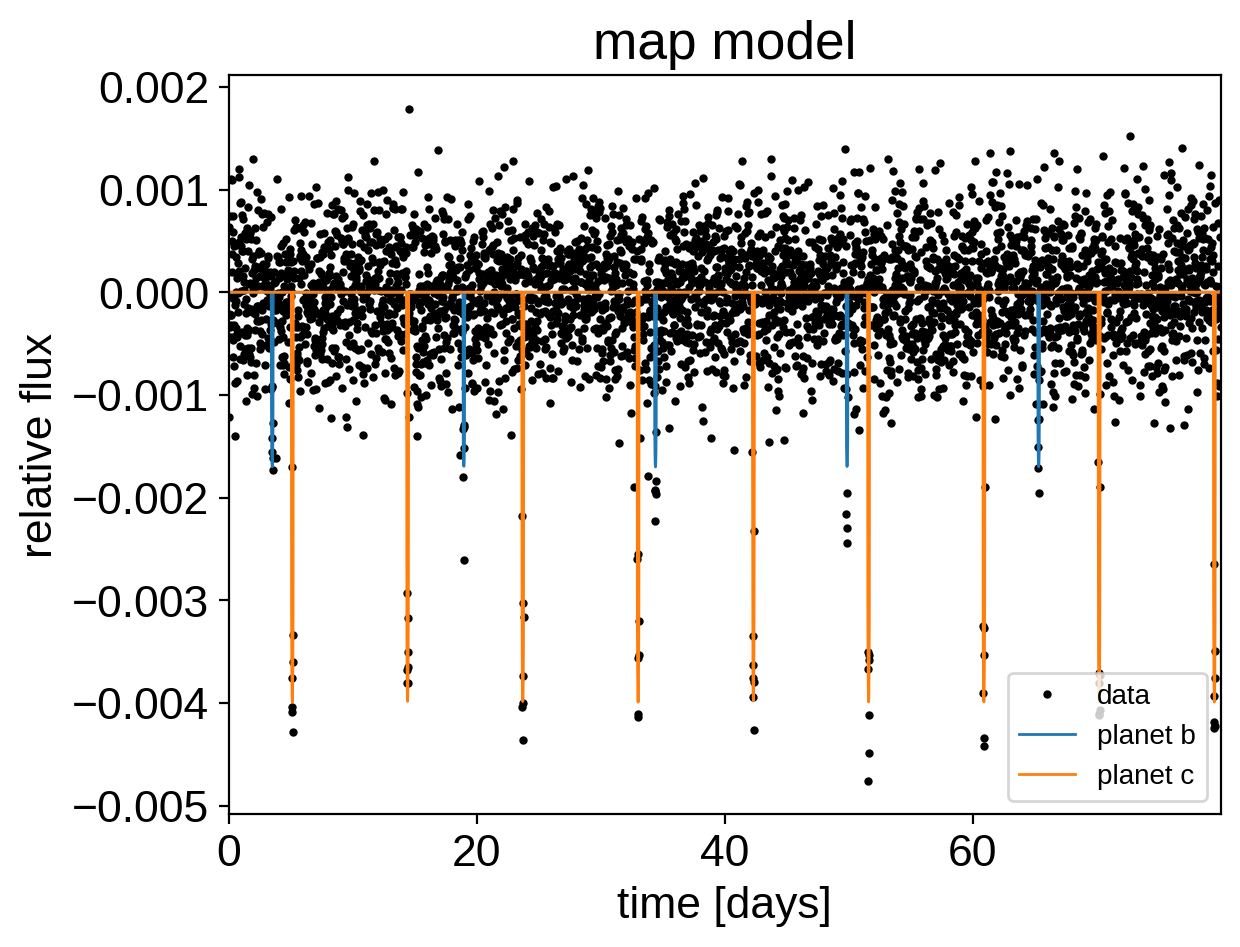

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [b, r, u, logP, t0, mean]


Sampling 2 chains, 0 divergences:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/12000 [00:00<04:10, 47.86draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/12000 [00:00<09:30, 21.02draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/12000 [00:00<12:56, 15.44draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/12000 [00:00<15:24, 12.96draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/12000 [00:01<17:06, 11.67draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/12000 [00:01<18:11, 10.97draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/12000 [00:01<19:05, 10.46draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/12000 [00:01<19:30, 10.23draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/12000 [00:01<19:55, 10.01draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/12000 [00:02<20:25,  9.77draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 31/12000 [00:02<20:27,  9.75draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 34/12000 [00:02<18:29, 10.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 36/12000 [00:02<19:12, 10.38draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 38/12000 [00:02<19:40, 10.13draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 40/12000 [00:03<20:05,  9.92draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 42/12000 [00:03<20:18,  9.81draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 44/12000 [00:03<20:30,  9.72draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 46/12000 [00:03<20:34,  9.68draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 49/12000 [00:04<18:41, 10.65draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 51/12000 [00:04<19:14, 10.35draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 53/12000 [00:04<19:47, 10.06draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 55/12000 [00:04<20:08,  9.89draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 57/12000 [00:04<20:43,  9.61draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 59/12000 [00:05<20:49,  9.55draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 61/12000 [00:05<20:54,  9.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 64/12000 [00:05<19:08, 10.39draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 66/12000 [00:05<19:44, 10.08draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 68/12000 [00:05<20:07,  9.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 70/12000 [00:06<20:22,  9.76draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 72/12000 [00:06<20:27,  9.71draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 74/12000 [00:06<20:32,  9.68draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 76/12000 [00:06<20:44,  9.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 78/12000 [00:06<20:40,  9.61draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 80/12000 [00:07<20:40,  9.61draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 82/12000 [00:07<20:53,  9.51draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 84/12000 [00:07<20:57,  9.48draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 87/12000 [00:07<18:45, 10.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 89/12000 [00:08<19:17, 10.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 91/12000 [00:08<19:59,  9.92draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 93/12000 [00:08<20:37,  9.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 95/12000 [00:08<20:47,  9.54draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 97/12000 [00:08<20:50,  9.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 99/12000 [00:09<20:46,  9.55draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 101/12000 [00:09<20:42,  9.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 103/12000 [00:09<20:37,  9.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 105/12000 [00:09<20:34,  9.64draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 107/12000 [00:09<20:30,  9.66draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 109/12000 [00:10<20:41,  9.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 111/12000 [00:10<20:41,  9.57draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 113/12000 [00:10<20:55,  9.47draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 115/12000 [00:10<20:56,  9.46draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 117/12000 [00:11<20:53,  9.48draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 119/12000 [00:11<21:11,  9.35draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 121/12000 [00:11<21:25,  9.24draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 123/12000 [00:11<21:14,  9.32draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 125/12000 [00:11<21:01,  9.41draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 128/12000 [00:12<18:59, 10.42draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 130/12000 [00:12<19:22, 10.21draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 132/12000 [00:12<19:45, 10.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 134/12000 [00:12<19:56,  9.92draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 136/12000 [00:12<20:08,  9.81draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 138/12000 [00:13<20:25,  9.68draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 140/12000 [00:13<20:37,  9.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 142/12000 [00:13<20:42,  9.54draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 144/12000 [00:13<20:51,  9.47draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 146/12000 [00:13<20:53,  9.46draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 148/12000 [00:14<20:53,  9.45draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 150/12000 [00:14<21:02,  9.39draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 152/12000 [00:14<20:56,  9.43draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 154/12000 [00:14<21:10,  9.33draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 156/12000 [00:15<20:55,  9.43draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 158/12000 [00:15<20:56,  9.42draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 160/12000 [00:15<20:56,  9.42draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 162/12000 [00:15<20:59,  9.40draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 164/12000 [00:15<20:54,  9.43draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 166/12000 [00:16<20:54,  9.44draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 168/12000 [00:16<20:45,  9.50draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 170/12000 [00:16<20:28,  9.63draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 172/12000 [00:16<20:19,  9.70draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 174/12000 [00:16<20:14,  9.74draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 176/12000 [00:17<20:16,  9.72draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 178/12000 [00:17<20:15,  9.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 180/12000 [00:17<20:15,  9.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 182/12000 [00:17<20:20,  9.68draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 184/12000 [00:17<20:51,  9.44draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 186/12000 [00:18<20:59,  9.38draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 189/12000 [00:18<19:19, 10.19draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 191/12000 [00:18<19:36, 10.04draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 193/12000 [00:18<21:03,  9.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 195/12000 [00:19<21:10,  9.29draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 197/12000 [00:19<21:08,  9.31draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 199/12000 [00:19<21:03,  9.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 201/12000 [00:19<20:52,  9.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 203/12000 [00:19<20:42,  9.49draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 205/12000 [00:20<20:42,  9.49draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 207/12000 [00:20<20:36,  9.53draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 209/12000 [00:20<21:02,  9.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 211/12000 [00:20<20:59,  9.36draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 213/12000 [00:20<20:49,  9.43draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 215/12000 [00:21<20:42,  9.49draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 217/12000 [00:21<20:38,  9.51draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 219/12000 [00:21<20:34,  9.54draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 221/12000 [00:21<20:31,  9.57draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 223/12000 [00:22<20:26,  9.60draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 225/12000 [00:22<20:27,  9.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 227/12000 [00:22<20:28,  9.58draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 229/12000 [00:22<20:25,  9.60draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 231/12000 [00:22<20:27,  9.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 233/12000 [00:23<20:28,  9.58draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 235/12000 [00:23<20:29,  9.57draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 237/12000 [00:23<20:28,  9.58draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 239/12000 [00:23<20:54,  9.37draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 241/12000 [00:23<20:50,  9.40draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 243/12000 [00:24<20:41,  9.47draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 245/12000 [00:24<20:30,  9.56draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 247/12000 [00:24<20:24,  9.60draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 249/12000 [00:24<20:22,  9.61draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 251/12000 [00:24<20:40,  9.47draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 253/12000 [00:25<20:38,  9.48draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 255/12000 [00:25<20:28,  9.56draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 257/12000 [00:25<20:26,  9.57draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 259/12000 [00:25<20:20,  9.62draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 261/12000 [00:26<20:28,  9.56draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 263/12000 [00:26<20:26,  9.57draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 265/12000 [00:26<20:25,  9.58draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 267/12000 [00:26<21:04,  9.28draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 269/12000 [00:26<20:56,  9.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 271/12000 [00:27<20:46,  9.41draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 273/12000 [00:27<20:39,  9.46draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 275/12000 [00:27<20:36,  9.49draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 277/12000 [00:27<20:33,  9.51draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 279/12000 [00:27<17:27, 11.19draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/12000 [00:28<18:31, 10.54draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 283/12000 [00:28<16:54, 11.55draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 285/12000 [00:28<17:59, 10.85draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 287/12000 [00:28<18:41, 10.45draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 289/12000 [00:28<19:11, 10.17draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 291/12000 [00:29<19:41,  9.91draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 293/12000 [00:29<19:54,  9.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 295/12000 [00:29<20:13,  9.65draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 297/12000 [00:29<20:19,  9.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 299/12000 [00:29<17:53, 10.90draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 303/12000 [00:29<14:16, 13.66draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 307/12000 [00:30<11:45, 16.57draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 310/12000 [00:30<10:41, 18.21draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 318/12000 [00:30<08:23, 23.19draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 323/12000 [00:30<07:07, 27.32draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 329/12000 [00:30<06:02, 32.15draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 335/12000 [00:30<05:17, 36.78draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 340/12000 [00:30<04:55, 39.44draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 345/12000 [00:30<04:45, 40.80draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 350/12000 [00:30<04:45, 40.87draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 358/12000 [00:31<04:04, 47.52draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 366/12000 [00:31<03:39, 53.08draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 374/12000 [00:31<03:22, 57.47draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 382/12000 [00:31<03:10, 61.12draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 389/12000 [00:31<03:03, 63.38draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 400/12000 [00:31<02:41, 71.94draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 410/12000 [00:31<02:28, 77.91draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 422/12000 [00:31<02:14, 86.26draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 432/12000 [00:31<02:15, 85.44draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 445/12000 [00:32<02:01, 94.94draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 456/12000 [00:32<01:56, 98.89draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 469/12000 [00:32<01:49, 105.72draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 481/12000 [00:32<01:52, 102.55draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 492/12000 [00:32<01:56, 98.77draws/s] 

Sampling 2 chains, 0 divergences:   4%|▍         | 507/12000 [00:32<01:44, 109.69draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 519/12000 [00:32<01:43, 110.55draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 532/12000 [00:32<01:40, 113.61draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 544/12000 [00:32<01:45, 109.10draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 558/12000 [00:32<01:38, 115.86draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 572/12000 [00:33<01:34, 120.70draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 586/12000 [00:33<01:31, 124.70draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 601/12000 [00:33<01:29, 127.74draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 614/12000 [00:33<01:35, 119.39draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 627/12000 [00:33<01:34, 120.29draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 640/12000 [00:33<01:35, 119.57draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 653/12000 [00:33<01:38, 115.65draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 666/12000 [00:33<01:36, 117.94draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 680/12000 [00:33<01:31, 123.31draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 696/12000 [00:34<01:26, 130.15draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 712/12000 [00:34<01:22, 136.53draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 730/12000 [00:34<01:18, 142.87draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 745/12000 [00:34<01:18, 142.56draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 761/12000 [00:34<01:17, 145.56draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 776/12000 [00:34<01:18, 142.36draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 791/12000 [00:34<01:18, 143.55draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 806/12000 [00:34<01:20, 139.19draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 822/12000 [00:34<01:18, 143.00draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 838/12000 [00:35<01:16, 145.37draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 853/12000 [00:35<01:18, 141.76draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 868/12000 [00:35<01:19, 139.89draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 884/12000 [00:35<01:17, 143.58draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 899/12000 [00:35<01:17, 142.86draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 914/12000 [00:35<01:19, 139.69draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 929/12000 [00:35<01:17, 141.99draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 945/12000 [00:35<01:16, 145.21draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 960/12000 [00:35<01:19, 139.37draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 975/12000 [00:36<01:19, 139.45draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 990/12000 [00:36<01:17, 141.26draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1005/12000 [00:36<01:20, 136.83draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1019/12000 [00:36<01:20, 135.60draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1033/12000 [00:36<01:24, 130.07draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1047/12000 [00:36<01:22, 132.47draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1063/12000 [00:36<01:20, 135.45draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1079/12000 [00:36<01:18, 140.00draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1094/12000 [00:36<01:17, 140.81draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1111/12000 [00:37<01:14, 145.44draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1126/12000 [00:37<01:15, 144.61draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1141/12000 [00:37<01:16, 141.93draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1159/12000 [00:37<01:11, 151.05draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1175/12000 [00:37<01:12, 148.66draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1191/12000 [00:37<01:14, 144.14draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1206/12000 [00:37<01:15, 143.74draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1221/12000 [00:37<01:14, 143.86draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1236/12000 [00:37<01:19, 135.21draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1250/12000 [00:37<01:19, 134.45draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1266/12000 [00:38<01:16, 140.34draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1284/12000 [00:38<01:12, 147.43draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1299/12000 [00:38<01:14, 144.43draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1314/12000 [00:38<01:16, 140.13draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1329/12000 [00:38<01:15, 141.11draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1346/12000 [00:38<01:13, 145.02draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1361/12000 [00:38<01:15, 141.32draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1376/12000 [00:38<01:15, 140.03draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1391/12000 [00:38<01:19, 133.30draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1406/12000 [00:39<01:18, 135.36draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1422/12000 [00:39<01:15, 140.67draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1441/12000 [00:39<01:09, 150.94draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1458/12000 [00:39<01:07, 155.32draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1474/12000 [00:39<01:08, 154.44draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1491/12000 [00:39<01:07, 155.40draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1507/12000 [00:39<01:09, 150.74draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1524/12000 [00:39<01:07, 154.39draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1543/12000 [00:39<01:05, 158.97draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1560/12000 [00:40<01:07, 155.51draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1576/12000 [00:40<01:08, 152.40draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1592/12000 [00:40<01:07, 154.17draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1612/12000 [00:40<01:03, 164.64draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1629/12000 [00:40<01:04, 160.54draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1646/12000 [00:40<01:08, 150.48draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1662/12000 [00:40<01:09, 148.98draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1679/12000 [00:40<01:07, 152.54draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1695/12000 [00:40<01:06, 154.04draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1711/12000 [00:41<01:12, 142.54draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1726/12000 [00:41<01:11, 143.07draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1741/12000 [00:41<01:11, 143.41draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1756/12000 [00:41<01:11, 143.67draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1773/12000 [00:41<01:09, 147.89draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1790/12000 [00:41<01:07, 151.45draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1806/12000 [00:41<01:06, 152.46draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1822/12000 [00:41<01:07, 150.68draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1838/12000 [00:41<01:08, 147.54draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1853/12000 [00:42<01:11, 141.37draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1868/12000 [00:42<01:13, 138.23draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1884/12000 [00:42<01:11, 141.78draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1901/12000 [00:42<01:09, 146.12draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1918/12000 [00:42<01:06, 152.38draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1934/12000 [00:42<01:05, 153.93draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1952/12000 [00:42<01:03, 158.67draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1969/12000 [00:42<01:04, 156.14draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1985/12000 [00:42<01:05, 153.36draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2001/12000 [00:42<01:06, 150.39draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2017/12000 [00:43<01:07, 147.06draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2032/12000 [00:43<01:07, 146.78draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2048/12000 [00:43<01:08, 146.34draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2063/12000 [00:43<01:08, 146.12draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2079/12000 [00:43<01:07, 147.58draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2099/12000 [00:43<01:02, 157.94draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2116/12000 [00:43<01:02, 157.10draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2133/12000 [00:43<01:01, 159.29draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2150/12000 [00:43<01:04, 153.45draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2166/12000 [00:44<01:05, 150.52draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2182/12000 [00:44<01:05, 150.18draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2198/12000 [00:44<01:04, 151.31draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2215/12000 [00:44<01:02, 156.45draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2233/12000 [00:44<00:59, 162.81draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2251/12000 [00:44<00:58, 165.25draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2268/12000 [00:44<00:58, 165.23draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2285/12000 [00:44<01:01, 157.23draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2301/12000 [00:44<01:04, 150.21draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2317/12000 [00:45<01:06, 144.91draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2333/12000 [00:45<01:06, 145.68draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2351/12000 [00:45<01:03, 152.91draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2367/12000 [00:45<01:06, 144.66draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2383/12000 [00:45<01:06, 145.49draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2400/12000 [00:45<01:03, 151.36draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2416/12000 [00:45<01:05, 146.89draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2432/12000 [00:45<01:04, 148.93draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2449/12000 [00:45<01:02, 152.67draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2465/12000 [00:46<01:05, 145.55draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2480/12000 [00:46<01:06, 144.07draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2495/12000 [00:46<01:05, 145.07draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2510/12000 [00:46<01:07, 141.22draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2525/12000 [00:46<01:06, 141.83draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2540/12000 [00:46<01:06, 142.55draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 2558/12000 [00:46<01:03, 149.57draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 2574/12000 [00:46<01:02, 150.43draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2590/12000 [00:46<01:02, 151.46draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2606/12000 [00:47<01:02, 150.65draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2622/12000 [00:47<01:05, 144.07draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2639/12000 [00:47<01:02, 149.75draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2655/12000 [00:47<01:03, 147.16draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2670/12000 [00:47<01:04, 143.79draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2685/12000 [00:47<01:06, 139.36draws/s]

Sampling 2 chains, 0 divergences:  22%|██▎       | 2700/12000 [00:47<01:07, 138.01draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2714/12000 [00:47<01:07, 137.06draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2732/12000 [00:47<01:03, 146.94draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2747/12000 [00:47<01:03, 146.80draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2762/12000 [00:48<01:04, 142.54draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2778/12000 [00:48<01:03, 146.35draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2793/12000 [00:48<01:03, 145.33draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2810/12000 [00:48<01:01, 150.42draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 2831/12000 [00:48<00:56, 163.47draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2851/12000 [00:48<00:53, 171.95draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2869/12000 [00:48<00:55, 165.64draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2887/12000 [00:48<00:55, 164.65draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2904/12000 [00:48<00:55, 162.66draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2921/12000 [00:49<00:56, 159.69draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2938/12000 [00:49<00:57, 156.62draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2954/12000 [00:49<00:58, 153.91draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2971/12000 [00:49<00:57, 157.13draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2987/12000 [00:49<00:59, 152.04draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3003/12000 [00:49<01:00, 148.78draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3018/12000 [00:49<01:00, 148.07draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3034/12000 [00:49<01:00, 149.16draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3049/12000 [00:49<01:00, 148.90draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3064/12000 [00:50<01:01, 144.25draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3079/12000 [00:50<01:02, 141.88draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3095/12000 [00:50<01:01, 145.30draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3110/12000 [00:50<01:02, 142.17draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3126/12000 [00:50<01:02, 142.93draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3145/12000 [00:50<00:58, 150.72draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 3161/12000 [00:50<00:59, 149.58draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 3178/12000 [00:50<00:56, 155.06draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3198/12000 [00:50<00:53, 163.85draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3217/12000 [00:51<00:53, 165.54draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3234/12000 [00:51<00:55, 157.81draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3251/12000 [00:51<00:55, 159.02draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3271/12000 [00:51<00:51, 168.04draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3289/12000 [00:51<00:52, 167.22draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3308/12000 [00:51<00:51, 170.06draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3326/12000 [00:51<00:53, 161.68draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3343/12000 [00:51<00:53, 162.30draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3360/12000 [00:51<00:55, 156.91draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3376/12000 [00:52<00:55, 155.32draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3392/12000 [00:52<00:54, 156.66draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3408/12000 [00:52<00:55, 155.60draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 3426/12000 [00:52<00:53, 160.55draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 3443/12000 [00:52<00:54, 157.91draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3460/12000 [00:52<00:53, 158.72draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3476/12000 [00:52<00:53, 158.97draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3494/12000 [00:52<00:51, 164.42draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3511/12000 [00:52<00:51, 164.32draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3528/12000 [00:52<00:54, 154.80draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3544/12000 [00:53<00:54, 154.83draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3560/12000 [00:53<00:56, 150.23draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3576/12000 [00:53<00:57, 145.81draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3592/12000 [00:53<00:56, 148.69draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3607/12000 [00:53<00:57, 146.29draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3622/12000 [00:53<00:58, 144.29draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3637/12000 [00:53<00:58, 142.14draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3652/12000 [00:53<00:59, 140.10draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3668/12000 [00:53<00:58, 143.44draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3683/12000 [00:54<00:57, 143.42draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3698/12000 [00:54<00:57, 145.28draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3714/12000 [00:54<00:57, 144.22draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3729/12000 [00:54<00:57, 143.16draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3746/12000 [00:54<00:55, 148.42draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 3762/12000 [00:54<00:55, 149.33draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 3779/12000 [00:54<00:53, 154.72draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3795/12000 [00:54<00:53, 153.27draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3811/12000 [00:54<00:53, 153.45draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3828/12000 [00:54<00:52, 155.52draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3844/12000 [00:55<00:53, 152.10draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3860/12000 [00:55<00:56, 142.86draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3878/12000 [00:55<00:53, 151.64draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3894/12000 [00:55<00:52, 153.53draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3910/12000 [00:55<00:53, 151.28draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3926/12000 [00:55<00:55, 144.90draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3942/12000 [00:55<00:55, 146.23draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3957/12000 [00:55<00:55, 145.53draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3974/12000 [00:55<00:53, 150.20draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3990/12000 [00:56<00:52, 152.98draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 4007/12000 [00:56<00:50, 156.81draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 4024/12000 [00:56<00:49, 159.59draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 4041/12000 [00:56<00:49, 159.38draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4057/12000 [00:56<00:50, 156.31draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4074/12000 [00:56<00:49, 159.20draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4090/12000 [00:56<00:49, 158.48draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4107/12000 [00:56<00:48, 161.53draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4124/12000 [00:56<00:50, 156.82draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4140/12000 [00:57<00:51, 153.08draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4156/12000 [00:57<00:51, 151.65draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4172/12000 [00:57<00:53, 146.95draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4187/12000 [00:57<00:53, 146.72draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4203/12000 [00:57<00:52, 147.54draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4218/12000 [00:57<00:53, 145.69draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4234/12000 [00:57<00:52, 149.12draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4251/12000 [00:57<00:51, 151.44draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4267/12000 [00:57<00:51, 151.00draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4283/12000 [00:57<00:51, 148.89draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4302/12000 [00:58<00:48, 157.14draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4318/12000 [00:58<00:51, 150.41draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4334/12000 [00:58<00:50, 152.15draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 4351/12000 [00:58<00:49, 155.80draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 4368/12000 [00:58<00:48, 158.83draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4384/12000 [00:58<00:49, 153.84draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4400/12000 [00:58<00:50, 151.00draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4416/12000 [00:58<00:49, 152.05draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4434/12000 [00:58<00:48, 155.27draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4453/12000 [00:59<00:47, 159.93draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4470/12000 [00:59<00:46, 161.03draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4487/12000 [00:59<00:46, 161.42draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4504/12000 [00:59<00:47, 158.50draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4521/12000 [00:59<00:46, 160.96draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4538/12000 [00:59<00:45, 162.75draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4555/12000 [00:59<00:47, 157.16draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4572/12000 [00:59<00:46, 159.48draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4589/12000 [00:59<00:48, 152.60draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4605/12000 [01:00<00:49, 148.09draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4620/12000 [01:00<00:50, 145.13draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 4635/12000 [01:00<00:53, 138.87draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4650/12000 [01:00<00:52, 139.57draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4667/12000 [01:00<00:50, 145.25draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4682/12000 [01:00<00:52, 140.65draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4697/12000 [01:00<00:52, 139.41draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4713/12000 [01:00<00:51, 142.62draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4729/12000 [01:00<00:49, 146.32draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4750/12000 [01:01<00:45, 158.78draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4767/12000 [01:01<00:44, 161.81draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4784/12000 [01:01<00:45, 160.18draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4801/12000 [01:01<00:44, 160.59draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4818/12000 [01:01<00:45, 158.72draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4834/12000 [01:01<00:45, 158.72draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4850/12000 [01:01<00:46, 155.43draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4866/12000 [01:01<00:46, 154.31draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4882/12000 [01:01<00:48, 146.59draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4899/12000 [01:01<00:47, 150.27draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4915/12000 [01:02<00:46, 151.04draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4931/12000 [01:02<00:46, 151.37draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4947/12000 [01:02<00:47, 148.86draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 4964/12000 [01:02<00:46, 152.33draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 4980/12000 [01:02<00:46, 149.79draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 4996/12000 [01:02<00:46, 152.15draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5012/12000 [01:02<00:46, 151.79draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5028/12000 [01:02<00:47, 147.94draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5043/12000 [01:02<00:47, 147.34draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5058/12000 [01:03<00:47, 145.74draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5074/12000 [01:03<00:46, 148.86draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5092/12000 [01:03<00:44, 155.12draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5108/12000 [01:03<00:45, 150.96draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5124/12000 [01:03<00:45, 152.38draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5140/12000 [01:03<00:44, 154.42draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5157/12000 [01:03<00:43, 155.61draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5173/12000 [01:03<00:44, 153.76draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5189/12000 [01:03<00:43, 154.97draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5205/12000 [01:04<00:43, 155.79draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 5221/12000 [01:04<00:43, 155.67draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 5238/12000 [01:04<00:43, 155.61draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5256/12000 [01:04<00:41, 161.73draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5273/12000 [01:04<00:41, 161.99draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5290/12000 [01:04<00:42, 159.22draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5307/12000 [01:04<00:42, 158.04draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5323/12000 [01:04<00:42, 158.33draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5339/12000 [01:04<00:42, 157.89draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5355/12000 [01:04<00:43, 153.82draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5376/12000 [01:05<00:39, 167.21draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5394/12000 [01:05<00:40, 161.77draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5411/12000 [01:05<00:41, 157.14draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5427/12000 [01:05<00:42, 153.70draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5443/12000 [01:05<00:43, 152.03draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5459/12000 [01:05<00:43, 149.44draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5475/12000 [01:05<00:43, 150.83draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5491/12000 [01:05<00:43, 150.18draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5507/12000 [01:05<00:43, 150.09draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5523/12000 [01:06<00:44, 144.55draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5540/12000 [01:06<00:43, 148.83draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 5556/12000 [01:06<00:42, 150.97draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 5573/12000 [01:06<00:41, 153.14draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5589/12000 [01:06<00:42, 149.64draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5605/12000 [01:06<00:42, 150.75draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5621/12000 [01:06<00:43, 146.70draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5636/12000 [01:06<00:43, 144.67draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5654/12000 [01:06<00:41, 152.63draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5670/12000 [01:07<00:41, 151.12draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5686/12000 [01:07<00:41, 151.92draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5703/12000 [01:07<00:40, 155.10draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5719/12000 [01:07<00:40, 155.77draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5735/12000 [01:07<00:40, 156.07draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5751/12000 [01:07<00:40, 152.58draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5767/12000 [01:07<00:41, 149.94draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5783/12000 [01:07<00:42, 147.18draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5798/12000 [01:07<00:43, 143.64draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5813/12000 [01:07<00:42, 144.57draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 5828/12000 [01:08<00:43, 142.94draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 5844/12000 [01:08<00:42, 146.20draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5859/12000 [01:08<00:41, 147.16draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5876/12000 [01:08<00:41, 148.78draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5892/12000 [01:08<00:40, 151.94draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5908/12000 [01:08<00:41, 147.28draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5925/12000 [01:08<00:39, 152.05draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5943/12000 [01:08<00:38, 158.38draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5959/12000 [01:08<00:39, 151.58draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5976/12000 [01:09<00:38, 154.65draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5992/12000 [01:09<00:38, 156.12draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6008/12000 [01:09<00:39, 150.35draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6024/12000 [01:09<00:39, 151.39draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6040/12000 [01:09<00:40, 145.78draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6056/12000 [01:09<00:40, 147.45draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6074/12000 [01:09<00:38, 153.18draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6090/12000 [01:09<00:38, 151.67draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6106/12000 [01:09<00:39, 148.33draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6122/12000 [01:10<00:39, 150.39draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6138/12000 [01:10<00:38, 152.22draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 6155/12000 [01:10<00:37, 155.90draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 6171/12000 [01:10<00:38, 153.06draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6188/12000 [01:10<00:37, 156.56draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6205/12000 [01:10<00:36, 159.40draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6221/12000 [01:10<00:37, 153.85draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6237/12000 [01:10<00:37, 155.39draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6254/12000 [01:10<00:36, 158.75draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6271/12000 [01:10<00:35, 161.36draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6288/12000 [01:11<00:36, 156.86draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6304/12000 [01:11<00:36, 156.40draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6320/12000 [01:11<00:37, 149.93draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6336/12000 [01:11<00:37, 151.07draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6352/12000 [01:11<00:37, 152.49draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6368/12000 [01:11<00:36, 153.21draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6385/12000 [01:11<00:35, 156.44draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6402/12000 [01:11<00:34, 160.17draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6419/12000 [01:11<00:35, 159.21draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 6435/12000 [01:12<00:36, 154.21draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6453/12000 [01:12<00:34, 160.18draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6470/12000 [01:12<00:35, 156.16draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6486/12000 [01:12<00:35, 154.85draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6502/12000 [01:12<00:35, 154.41draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6519/12000 [01:12<00:35, 156.30draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6535/12000 [01:12<00:35, 155.58draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6551/12000 [01:12<00:35, 155.44draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6568/12000 [01:12<00:34, 156.66draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6586/12000 [01:12<00:33, 160.28draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6604/12000 [01:13<00:32, 164.83draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6621/12000 [01:13<00:33, 162.31draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6638/12000 [01:13<00:33, 161.47draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6655/12000 [01:13<00:33, 157.89draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6671/12000 [01:13<00:34, 155.68draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6687/12000 [01:13<00:34, 153.20draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6703/12000 [01:13<00:35, 149.12draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6720/12000 [01:13<00:34, 151.48draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6736/12000 [01:13<00:34, 153.27draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 6752/12000 [01:14<00:34, 152.11draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 6769/12000 [01:14<00:34, 152.68draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6787/12000 [01:14<00:33, 156.35draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6803/12000 [01:14<00:33, 156.53draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6819/12000 [01:14<00:33, 152.96draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6835/12000 [01:14<00:34, 151.83draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6851/12000 [01:14<00:33, 151.70draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6868/12000 [01:14<00:33, 153.45draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6884/12000 [01:14<00:33, 150.65draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▊    | 6900/12000 [01:15<00:34, 149.49draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6916/12000 [01:15<00:33, 151.82draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6932/12000 [01:15<00:34, 147.79draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6947/12000 [01:15<00:34, 146.32draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6963/12000 [01:15<00:33, 150.17draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6979/12000 [01:15<00:33, 150.17draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6995/12000 [01:15<00:32, 152.88draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 7011/12000 [01:15<00:32, 154.36draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 7027/12000 [01:15<00:32, 152.66draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 7043/12000 [01:15<00:32, 154.22draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7059/12000 [01:16<00:34, 143.87draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7075/12000 [01:16<00:33, 147.49draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7091/12000 [01:16<00:33, 148.08draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7106/12000 [01:16<00:33, 145.03draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7125/12000 [01:16<00:31, 155.21draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7141/12000 [01:16<00:31, 156.22draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7157/12000 [01:16<00:30, 157.21draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7173/12000 [01:16<00:30, 156.28draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7189/12000 [01:16<00:31, 153.45draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7206/12000 [01:17<00:30, 157.46draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7222/12000 [01:17<00:30, 157.66draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7238/12000 [01:17<00:31, 150.96draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7255/12000 [01:17<00:30, 154.75draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7271/12000 [01:17<00:30, 155.08draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7288/12000 [01:17<00:30, 156.55draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7304/12000 [01:17<00:31, 150.33draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7320/12000 [01:17<00:30, 152.78draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7336/12000 [01:17<00:30, 152.61draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 7352/12000 [01:17<00:30, 152.79draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 7368/12000 [01:18<00:31, 146.14draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7384/12000 [01:18<00:30, 149.98draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7400/12000 [01:18<00:30, 150.79draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7416/12000 [01:18<00:30, 149.79draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7432/12000 [01:18<00:30, 151.04draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7448/12000 [01:18<00:31, 144.09draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7463/12000 [01:18<00:31, 144.00draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7478/12000 [01:18<00:32, 140.20draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7493/12000 [01:18<00:31, 140.85draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7508/12000 [01:19<00:31, 142.07draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7523/12000 [01:19<00:31, 143.97draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7540/12000 [01:19<00:30, 147.97draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7555/12000 [01:19<00:30, 146.83draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7572/12000 [01:19<00:29, 148.85draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7587/12000 [01:19<00:29, 147.79draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7604/12000 [01:19<00:29, 149.53draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7619/12000 [01:19<00:29, 148.49draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 7634/12000 [01:19<00:29, 146.95draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7651/12000 [01:20<00:29, 149.75draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7668/12000 [01:20<00:28, 154.27draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7684/12000 [01:20<00:28, 150.26draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7700/12000 [01:20<00:28, 151.41draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7717/12000 [01:20<00:27, 155.09draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7733/12000 [01:20<00:27, 156.30draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7749/12000 [01:20<00:27, 157.20draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7765/12000 [01:20<00:27, 155.25draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7781/12000 [01:20<00:27, 153.69draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7797/12000 [01:20<00:27, 155.03draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7813/12000 [01:21<00:27, 154.56draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7829/12000 [01:21<00:26, 154.56draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7845/12000 [01:21<00:26, 156.13draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7861/12000 [01:21<00:27, 151.93draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7877/12000 [01:21<00:26, 154.10draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7894/12000 [01:21<00:26, 155.16draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7910/12000 [01:21<00:26, 152.99draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7926/12000 [01:21<00:27, 147.31draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7943/12000 [01:21<00:27, 150.21draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 7959/12000 [01:22<00:26, 150.87draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 7976/12000 [01:22<00:25, 155.67draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 7995/12000 [01:22<00:24, 162.18draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8012/12000 [01:22<00:25, 155.33draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8028/12000 [01:22<00:25, 154.04draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8045/12000 [01:22<00:25, 157.30draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8061/12000 [01:22<00:25, 156.80draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8077/12000 [01:22<00:25, 154.86draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8093/12000 [01:22<00:25, 155.72draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8109/12000 [01:22<00:25, 154.44draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8125/12000 [01:23<00:24, 155.52draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8141/12000 [01:23<00:24, 155.81draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8157/12000 [01:23<00:25, 150.00draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8173/12000 [01:23<00:25, 151.83draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8191/12000 [01:23<00:24, 155.05draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8207/12000 [01:23<00:24, 155.05draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 8223/12000 [01:23<00:24, 155.87draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 8239/12000 [01:23<00:24, 150.93draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8256/12000 [01:23<00:24, 151.63draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8274/12000 [01:24<00:23, 155.92draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8290/12000 [01:24<00:23, 155.44draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8309/12000 [01:24<00:22, 161.89draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8326/12000 [01:24<00:23, 158.80draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8342/12000 [01:24<00:23, 154.13draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8358/12000 [01:24<00:24, 150.46draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8374/12000 [01:24<00:24, 149.94draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8390/12000 [01:24<00:24, 147.19draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8407/12000 [01:24<00:23, 153.35draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8423/12000 [01:25<00:23, 154.23draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8439/12000 [01:25<00:23, 153.84draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8455/12000 [01:25<00:23, 149.68draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8471/12000 [01:25<00:23, 151.75draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8487/12000 [01:25<00:22, 152.75draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8503/12000 [01:25<00:23, 148.59draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8518/12000 [01:25<00:24, 144.67draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8534/12000 [01:25<00:23, 146.15draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 8553/12000 [01:25<00:22, 152.87draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 8569/12000 [01:25<00:22, 154.53draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8585/12000 [01:26<00:22, 150.10draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8603/12000 [01:26<00:22, 153.98draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8620/12000 [01:26<00:21, 157.52draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8636/12000 [01:26<00:21, 156.32draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8652/12000 [01:26<00:21, 155.37draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8668/12000 [01:26<00:21, 153.48draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8684/12000 [01:26<00:21, 155.07draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▎  | 8700/12000 [01:26<00:21, 152.65draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8717/12000 [01:26<00:21, 154.91draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8733/12000 [01:27<00:21, 152.10draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8749/12000 [01:27<00:21, 153.48draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8765/12000 [01:27<00:21, 147.94draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8782/12000 [01:27<00:21, 150.80draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8799/12000 [01:27<00:20, 154.63draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8816/12000 [01:27<00:20, 158.59draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 8832/12000 [01:27<00:20, 151.86draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8850/12000 [01:27<00:20, 157.40draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8866/12000 [01:27<00:20, 150.54draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8882/12000 [01:28<00:20, 151.98draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8898/12000 [01:28<00:20, 151.64draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8915/12000 [01:28<00:19, 154.43draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8933/12000 [01:28<00:19, 160.03draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8950/12000 [01:28<00:19, 158.18draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8966/12000 [01:28<00:19, 157.16draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8983/12000 [01:28<00:18, 159.64draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9000/12000 [01:28<00:18, 161.29draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9017/12000 [01:28<00:19, 155.93draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9033/12000 [01:28<00:19, 155.58draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9049/12000 [01:29<00:19, 153.80draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9065/12000 [01:29<00:18, 155.15draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9084/12000 [01:29<00:18, 159.98draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9101/12000 [01:29<00:18, 160.13draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9118/12000 [01:29<00:18, 159.74draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9135/12000 [01:29<00:17, 161.41draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 9152/12000 [01:29<00:18, 155.60draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 9169/12000 [01:29<00:18, 155.41draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9185/12000 [01:29<00:18, 154.60draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9201/12000 [01:30<00:18, 154.61draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9217/12000 [01:30<00:18, 152.89draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9233/12000 [01:30<00:18, 153.34draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9249/12000 [01:30<00:17, 153.66draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9265/12000 [01:30<00:17, 153.74draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9282/12000 [01:30<00:17, 157.23draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9298/12000 [01:30<00:17, 153.38draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9315/12000 [01:30<00:17, 154.01draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9331/12000 [01:30<00:17, 153.45draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9347/12000 [01:31<00:17, 149.98draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9363/12000 [01:31<00:17, 151.44draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9381/12000 [01:31<00:16, 158.23draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9397/12000 [01:31<00:16, 157.38draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9413/12000 [01:31<00:16, 157.53draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 9430/12000 [01:31<00:16, 159.82draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 9447/12000 [01:31<00:16, 158.46draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9463/12000 [01:31<00:16, 155.52draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9479/12000 [01:31<00:16, 152.52draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9495/12000 [01:31<00:16, 151.99draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9511/12000 [01:32<00:16, 146.72draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9528/12000 [01:32<00:16, 149.67draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9546/12000 [01:32<00:15, 153.80draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9562/12000 [01:32<00:15, 153.68draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9580/12000 [01:32<00:15, 157.37draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9597/12000 [01:32<00:15, 158.00draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9614/12000 [01:32<00:14, 159.07draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9630/12000 [01:32<00:15, 156.11draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9646/12000 [01:32<00:15, 156.44draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9662/12000 [01:33<00:15, 155.16draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9681/12000 [01:33<00:14, 164.01draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9698/12000 [01:33<00:14, 162.24draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9715/12000 [01:33<00:14, 154.74draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9734/12000 [01:33<00:14, 159.58draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 9751/12000 [01:33<00:14, 157.13draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 9767/12000 [01:33<00:14, 156.66draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9784/12000 [01:33<00:13, 158.72draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9801/12000 [01:33<00:13, 161.55draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9818/12000 [01:33<00:13, 160.58draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9835/12000 [01:34<00:14, 148.08draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9851/12000 [01:34<00:14, 151.15draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9867/12000 [01:34<00:14, 148.95draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9883/12000 [01:34<00:14, 151.21draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9899/12000 [01:34<00:14, 149.79draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9915/12000 [01:34<00:13, 151.51draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9932/12000 [01:34<00:13, 154.68draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9948/12000 [01:34<00:13, 153.13draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9964/12000 [01:34<00:13, 153.65draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9980/12000 [01:35<00:13, 152.84draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9996/12000 [01:35<00:13, 153.65draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10012/12000 [01:35<00:12, 154.92draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 10028/12000 [01:35<00:12, 155.61draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 10044/12000 [01:35<00:12, 155.23draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10060/12000 [01:35<00:12, 156.37draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10076/12000 [01:35<00:12, 153.87draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10092/12000 [01:35<00:12, 151.42draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10108/12000 [01:35<00:12, 152.21draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10124/12000 [01:36<00:12, 151.74draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10140/12000 [01:36<00:12, 152.57draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10157/12000 [01:36<00:11, 155.65draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10173/12000 [01:36<00:11, 153.79draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10189/12000 [01:36<00:11, 154.38draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10205/12000 [01:36<00:11, 153.28draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10221/12000 [01:36<00:11, 151.80draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10237/12000 [01:36<00:11, 150.99draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10253/12000 [01:36<00:11, 153.53draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10270/12000 [01:36<00:11, 155.60draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10286/12000 [01:37<00:11, 154.06draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10302/12000 [01:37<00:11, 150.01draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10318/12000 [01:37<00:11, 149.28draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10335/12000 [01:37<00:10, 153.27draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 10352/12000 [01:37<00:10, 156.31draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 10369/12000 [01:37<00:10, 159.38draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10385/12000 [01:37<00:10, 159.00draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10401/12000 [01:37<00:10, 156.04draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10417/12000 [01:37<00:10, 153.67draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10433/12000 [01:38<00:10, 153.05draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10449/12000 [01:38<00:10, 150.75draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10465/12000 [01:38<00:10, 151.50draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10481/12000 [01:38<00:10, 150.83draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10497/12000 [01:38<00:10, 149.59draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10514/12000 [01:38<00:09, 151.23draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10530/12000 [01:38<00:09, 152.01draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10547/12000 [01:38<00:09, 151.57draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10564/12000 [01:38<00:09, 156.33draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10581/12000 [01:38<00:09, 156.75draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10597/12000 [01:39<00:08, 156.86draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10613/12000 [01:39<00:09, 153.67draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 10629/12000 [01:39<00:08, 154.44draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 10645/12000 [01:39<00:08, 152.90draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10661/12000 [01:39<00:08, 150.68draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10677/12000 [01:39<00:08, 151.49draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10693/12000 [01:39<00:08, 147.10draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10708/12000 [01:39<00:08, 146.72draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10725/12000 [01:39<00:08, 152.55draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10742/12000 [01:40<00:08, 156.96draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10758/12000 [01:40<00:08, 146.27draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10773/12000 [01:40<00:08, 146.88draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10789/12000 [01:40<00:08, 150.28draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10805/12000 [01:40<00:08, 145.90draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10822/12000 [01:40<00:07, 151.68draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10838/12000 [01:40<00:07, 147.31draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10853/12000 [01:40<00:07, 145.20draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10869/12000 [01:40<00:07, 147.38draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10885/12000 [01:41<00:07, 149.53draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10902/12000 [01:41<00:07, 153.37draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10918/12000 [01:41<00:07, 149.91draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10934/12000 [01:41<00:07, 150.43draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 10950/12000 [01:41<00:07, 148.41draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 10967/12000 [01:41<00:06, 151.40draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 10983/12000 [01:41<00:06, 153.71draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11000/12000 [01:41<00:06, 155.13draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11016/12000 [01:41<00:06, 154.13draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11032/12000 [01:41<00:06, 151.75draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11048/12000 [01:42<00:06, 149.46draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11064/12000 [01:42<00:06, 150.65draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11080/12000 [01:42<00:06, 151.28draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11096/12000 [01:42<00:05, 151.88draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11113/12000 [01:42<00:05, 154.94draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11130/12000 [01:42<00:05, 158.37draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11146/12000 [01:42<00:05, 155.47draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11162/12000 [01:42<00:05, 152.20draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11181/12000 [01:42<00:05, 158.05draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11200/12000 [01:43<00:04, 164.25draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11217/12000 [01:43<00:04, 158.36draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 11233/12000 [01:43<00:05, 152.32draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 11249/12000 [01:43<00:04, 153.63draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11265/12000 [01:43<00:04, 154.90draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11282/12000 [01:43<00:04, 158.75draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11299/12000 [01:43<00:04, 158.41draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11315/12000 [01:43<00:04, 158.63draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11332/12000 [01:43<00:04, 160.47draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11349/12000 [01:43<00:04, 157.43draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11365/12000 [01:44<00:04, 151.57draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11382/12000 [01:44<00:03, 155.73draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11398/12000 [01:44<00:03, 153.83draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11414/12000 [01:44<00:03, 152.39draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11431/12000 [01:44<00:03, 155.74draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11448/12000 [01:44<00:03, 158.38draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11464/12000 [01:44<00:03, 150.83draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11480/12000 [01:44<00:03, 149.47draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11496/12000 [01:44<00:03, 146.41draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11511/12000 [01:45<00:03, 145.51draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11526/12000 [01:45<00:03, 146.64draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11542/12000 [01:45<00:03, 148.52draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 11558/12000 [01:45<00:02, 149.84draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 11574/12000 [01:45<00:02, 150.26draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11592/12000 [01:45<00:02, 154.52draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11608/12000 [01:45<00:02, 151.25draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11625/12000 [01:45<00:02, 153.35draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11641/12000 [01:45<00:02, 150.45draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11657/12000 [01:46<00:02, 152.19draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11674/12000 [01:46<00:02, 156.20draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11690/12000 [01:46<00:02, 150.30draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11706/12000 [01:46<00:02, 145.02draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11722/12000 [01:46<00:01, 147.98draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11738/12000 [01:46<00:01, 150.22draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11755/12000 [01:46<00:01, 155.38draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11771/12000 [01:46<00:01, 155.71draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11787/12000 [01:46<00:01, 152.98draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11803/12000 [01:46<00:01, 153.71draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11819/12000 [01:47<00:01, 138.15draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 11834/12000 [01:47<00:01, 115.17draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 11847/12000 [01:47<00:01, 104.00draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11859/12000 [01:47<00:01, 95.86draws/s] 

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11870/12000 [01:47<00:01, 87.70draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11880/12000 [01:47<00:01, 85.26draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11889/12000 [01:48<00:01, 83.65draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11898/12000 [01:48<00:01, 84.87draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11907/12000 [01:48<00:01, 83.71draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11916/12000 [01:48<00:01, 83.30draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11925/12000 [01:48<00:00, 83.52draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11934/12000 [01:48<00:00, 80.64draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11943/12000 [01:48<00:00, 77.37draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11952/12000 [01:48<00:00, 79.05draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11960/12000 [01:48<00:00, 79.27draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11969/12000 [01:48<00:00, 81.83draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11978/12000 [01:49<00:00, 82.72draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11987/12000 [01:49<00:00, 84.24draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11996/12000 [01:49<00:00, 84.19draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [01:49<00:00, 109.71draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
period[0],15.448,0.002,15.444,15.452,0.000,0.000,2173.0,2173.0,2435.0,3030.0,1.0
period[1],9.292,0.000,9.292,9.293,0.000,0.000,4484.0,4484.0,4513.0,4124.0,1.0
t0[0],3.503,0.006,3.493,3.514,0.000,0.000,2195.0,2194.0,2428.0,3254.0,1.0
t0[1],5.121,0.001,5.119,5.124,0.000,0.000,5800.0,5800.0,5907.0,3235.0,1.0
r[0],0.040,0.002,0.037,0.042,0.000,0.000,2453.0,2453.0,2500.0,3439.0,1.0
r[1],0.058,0.001,0.056,0.060,0.000,0.000,2624.0,2624.0,2676.0,3415.0,1.0
b[0],0.671,0.046,0.583,0.740,0.001,0.001,1581.0,1581.0,1861.0,2343.0,1.0
b[1],0.403,0.038,0.332,0.469,0.001,0.001,2438.0,2438.0,2610.0,2983.0,1.0
u[0],0.378,0.207,0.001,0.717,0.003,0.002,4506.0,4506.0,4302.0,3714.0,1.0
u[1],0.268,0.340,-0.336,0.830,0.007,0.005,2736.0,2534.0,2640.0,3023.0,1.0


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

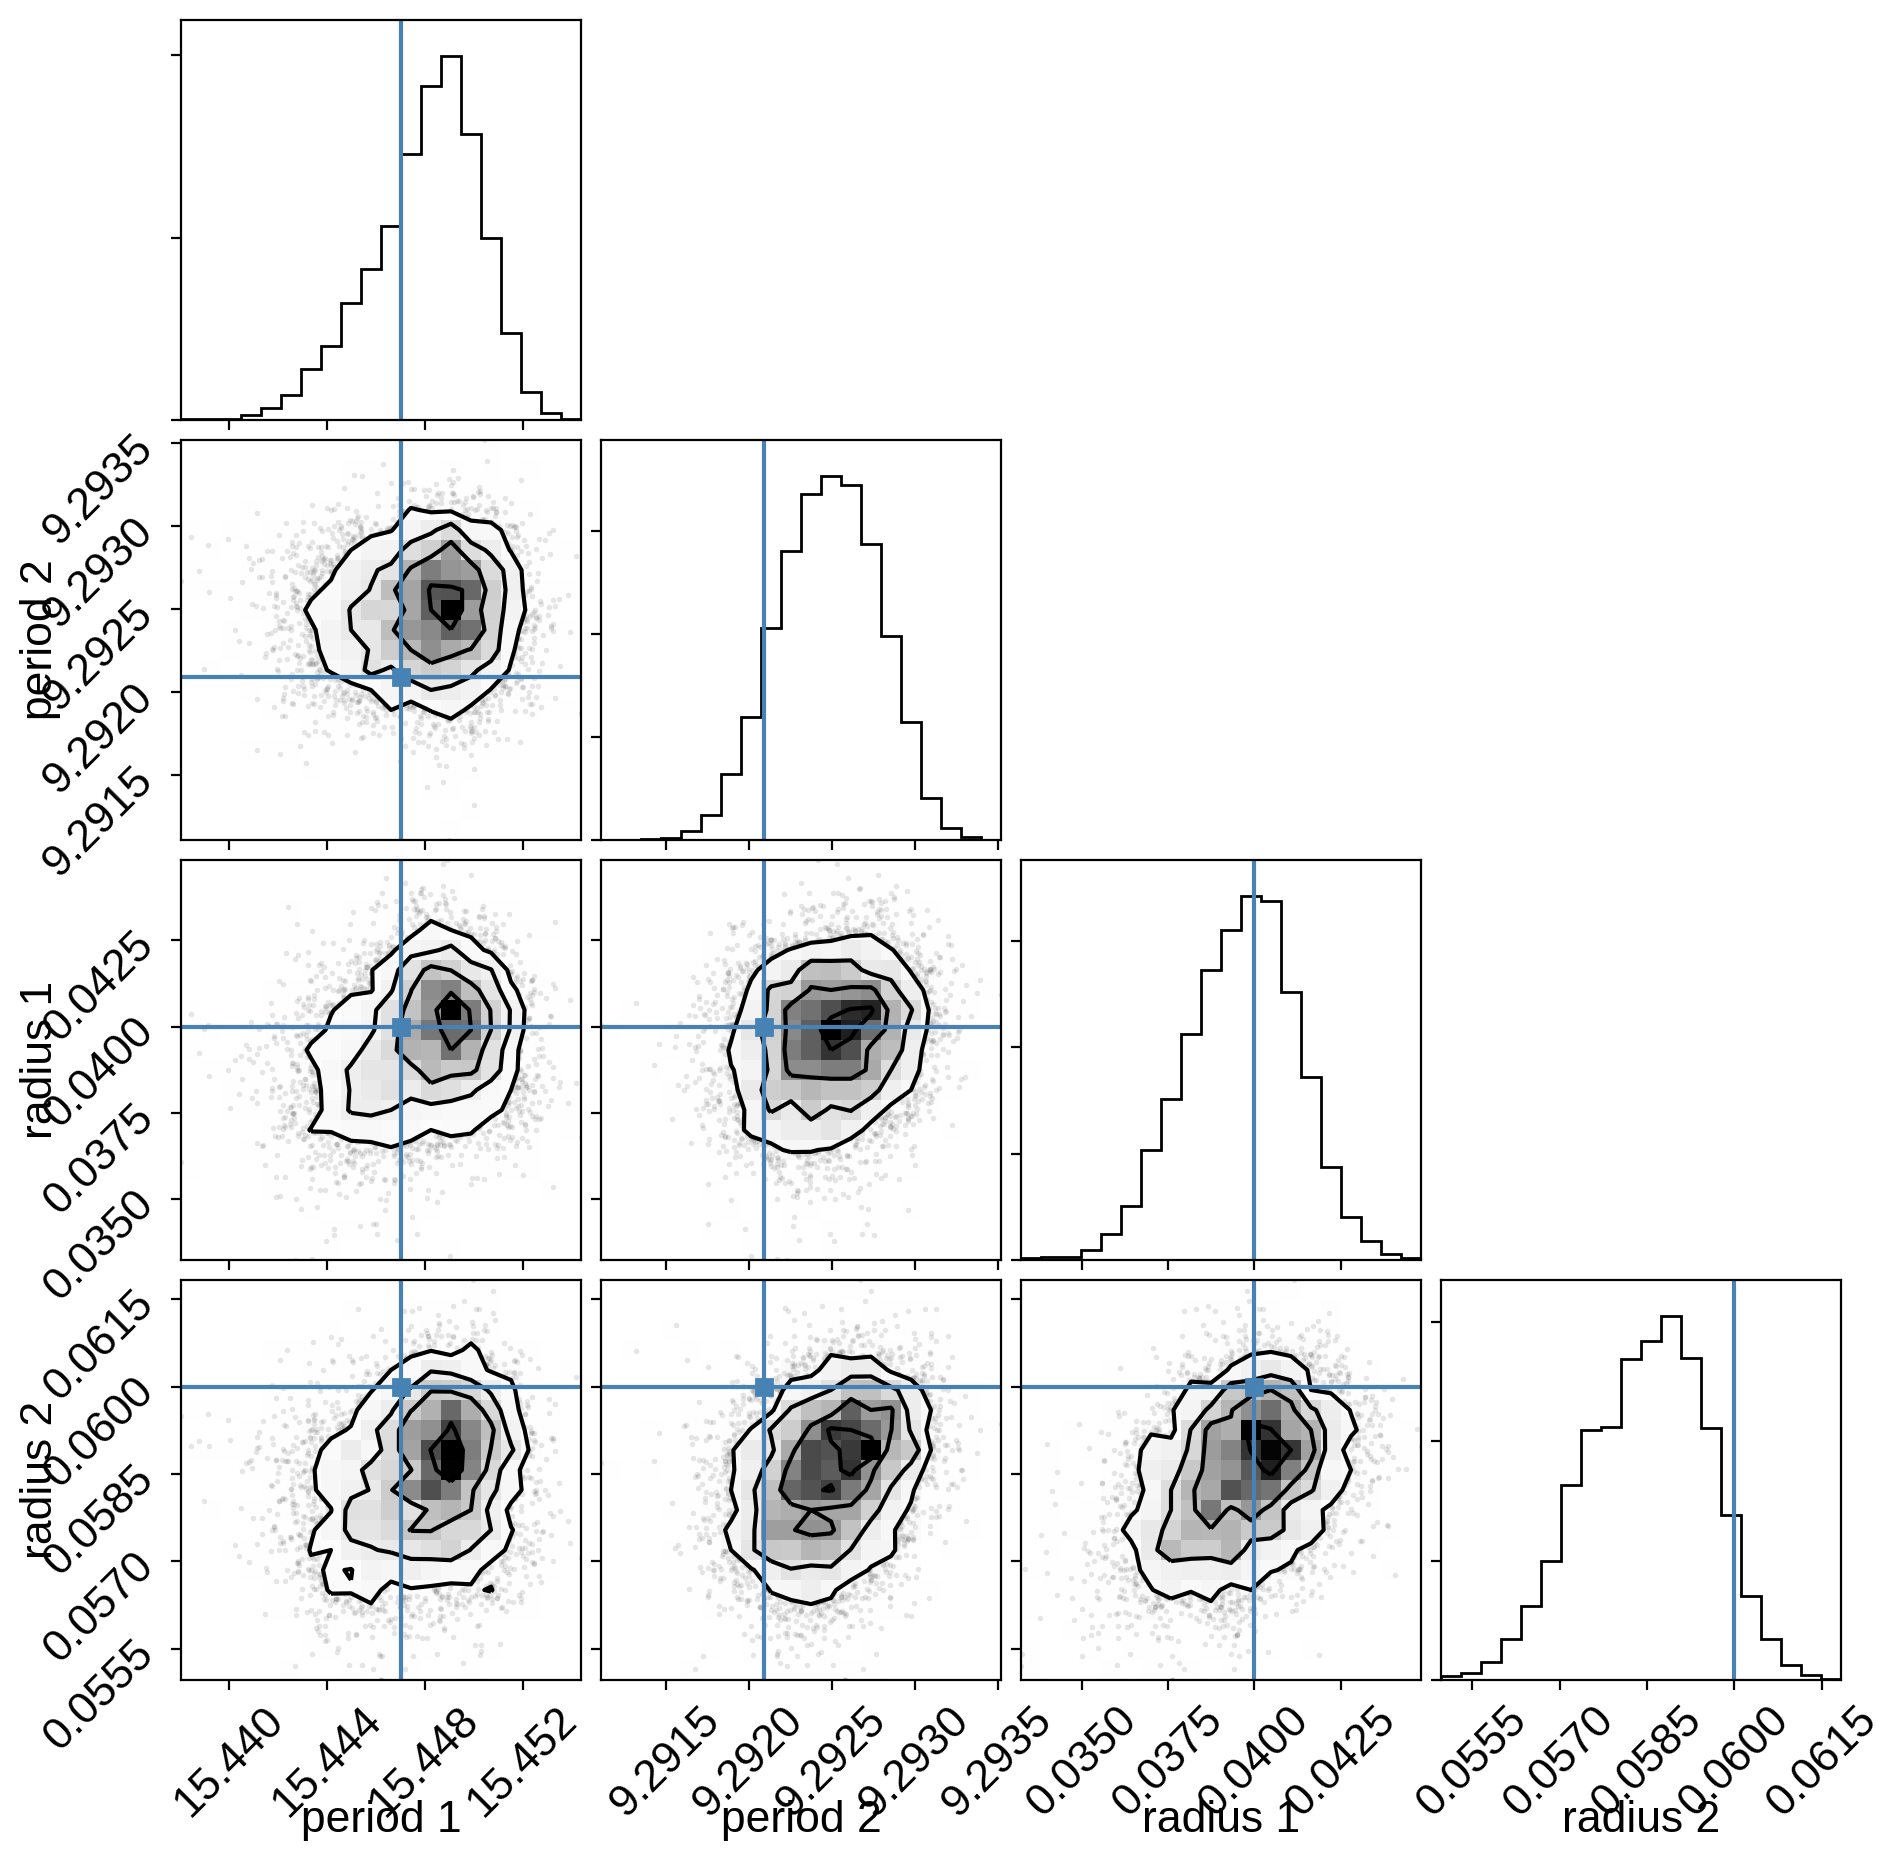

In [9]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(
    xo.eval_in_model([period, r], model.test_point, model=model)
)
_ = corner.corner(
    samples,
    truths=truth,
    labels=["period 1", "period 2", "radius 1", "radius 2"],
)

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

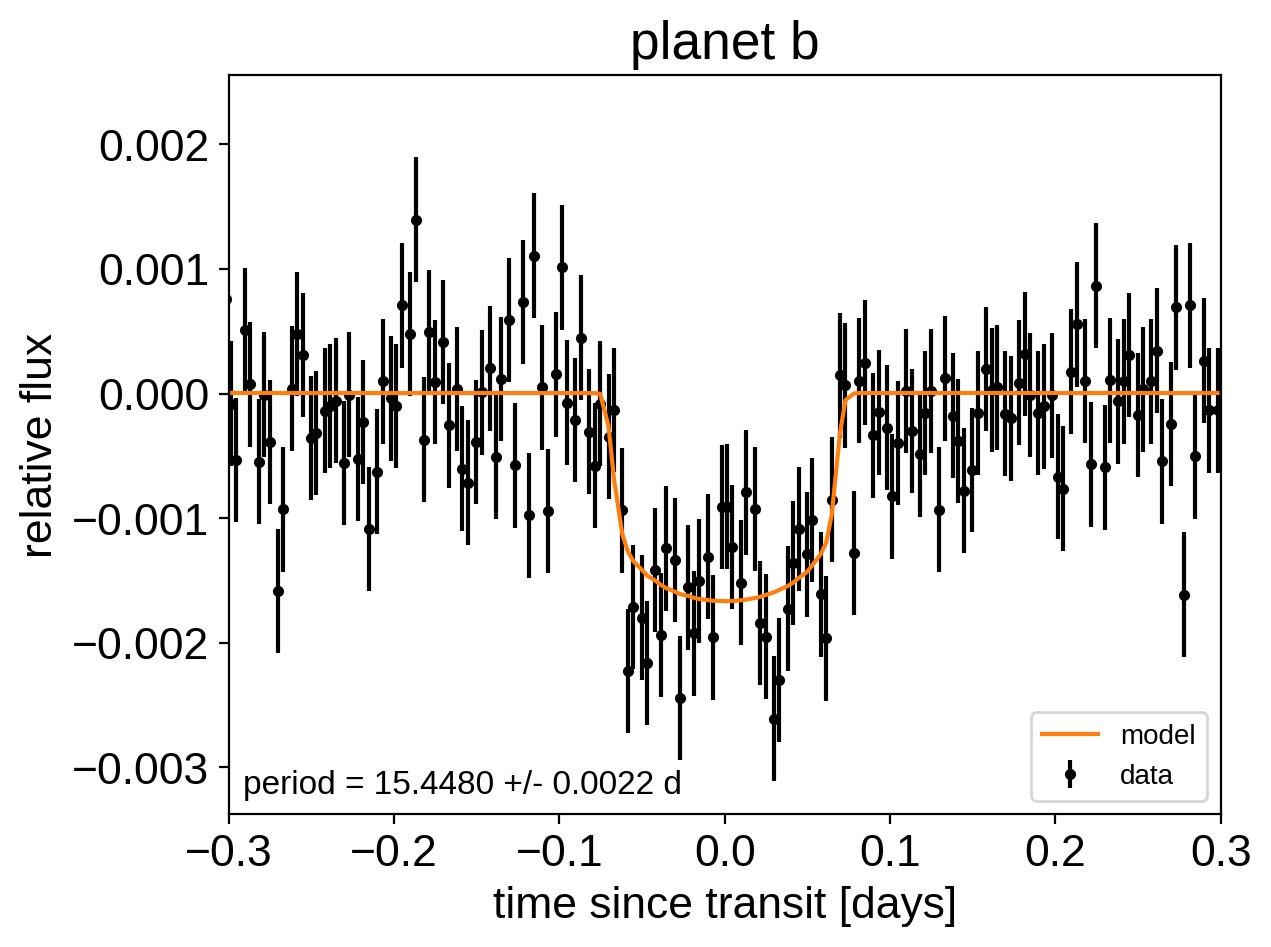

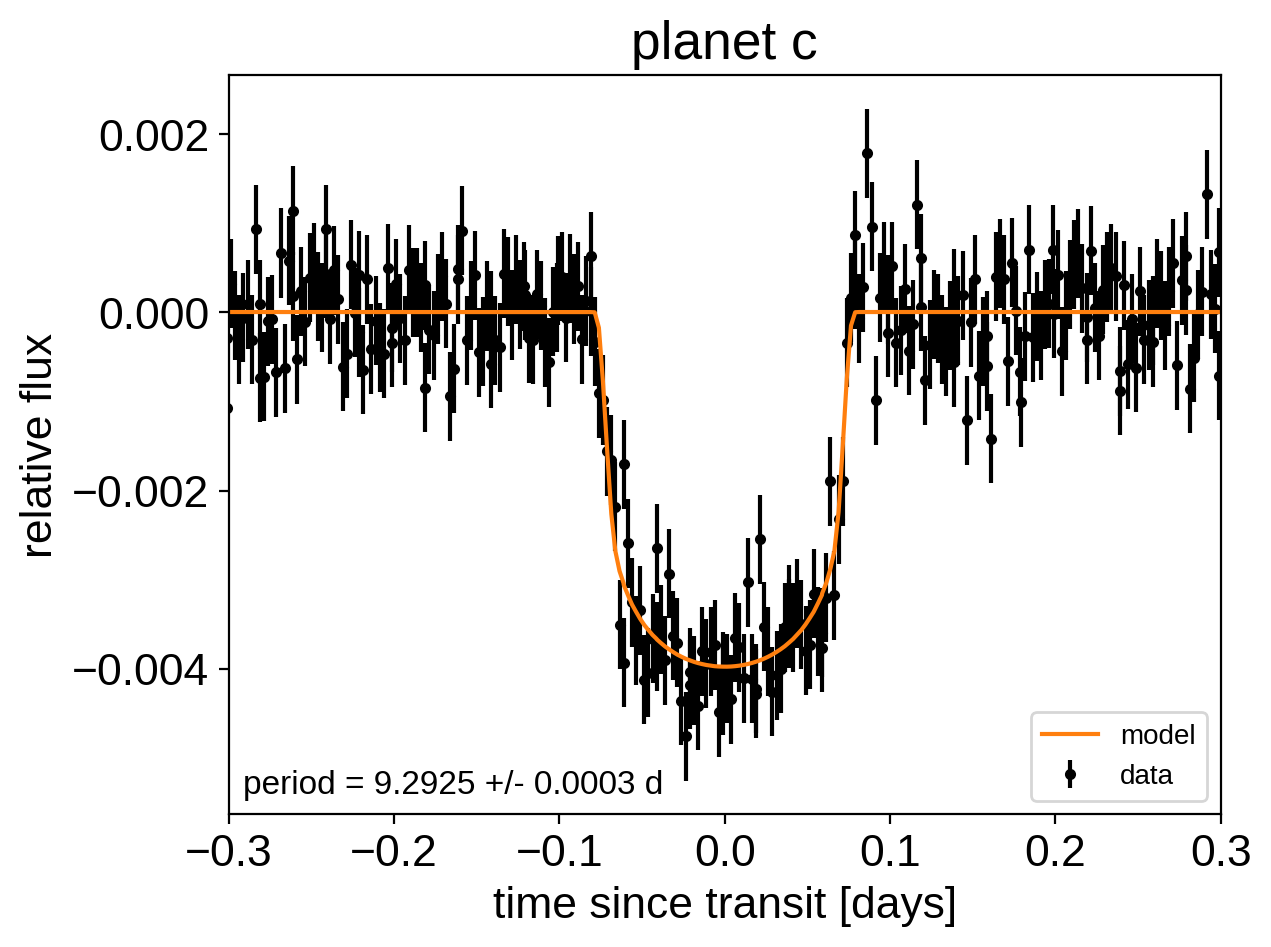

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.0},
   month = apr,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
